# Recommendation System
By Victor Mwatu

### Summary

This is a project whose goal is the creation of a machine learning algorithm that gives movie recommendations based on their ratings of movies in a dataset, which in this case was the Movielense dataset. 

The dataset contains several files but the ones of interest will are the ratings file containing the user ratings and the movies file with movie names.

The dataset after importing to Pandas Dataframe format has no missing values and only the timestamp field is drop as it is not relevant. A surprise dataset object is then created which will be used with the Surprise python library for recommendation systems.

Next operation is the creation of a simple baseline modelling process. It is achieved using a loop that loops through several simple memory based models and a simple basic SVD model for validating. The best performing model turns out to be the simple SVD with an RMSE of 0.877 and the worst is the KNN-basic with RMSE of 0.977. After that an SVD model is optimised using GridsearchCV to produce an optimum parameter model which is trained on the rest of the data. The final model had a RMSE of around 0.86 which is lower than that of the baseline.

A new user's data is merged with the dataset and compiled. The model is then able to provide user ratings for other movies and by selecting the movies with the highest ratings the user can be recommended top movies.


## 1. Business Understanding

This project aims to create a machine learning model that recommends movies to a user based on the user's ratings of other movies or if there is no data about the user, it recommends movies simmilar to one selected by the user.

The main stakeholders in this project is streaming services such as Netflix or any service that offers a wide selection of movies or simmilar products, and also users of such services. 

There has been an increase in the number and variety of products that can be offered to a customer due to the advancement of online stores and services. These stores are capable of having very large virtual portfolios to select from, something that was not possible with brick and motar stores due to physical constraints. This creates a problem when it comes to selection of a product by a customer.

Selecting one out of possibly millions of available options is a difficult task. A customer may end up with products that are not of their liking if they select randomly, or they may have to tidiousely look through a lot of options to find a suitable one. This is both bad for the customers as it is time consuming and unpleasant, and for the business as it may lead to loss of interest by customers and therefore loss of revenue.

The recommendation system modelled in this project will provide a customer with a set of smaller options that are easier to choose from, that are based on the customers preferences if available, also known as collaborative filtering, or based on a product selected by the customer, a method known as content based filtering.

## 2. Data Understanding

The data that will be used to make movie recommendations is the 'Movielense' dataset from the GroupLens research lab at the University of Minnesota. This is a well known dataset used in many recommendation system academic papers and machine learning proof of concept. 

It contains "100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users." according to its description. For further reference, the dataset and the Readme file describing it are in the file containing this notebook. 

Generally the dataset  contains four files:

**1. Links:** This file contains links to other websites. This file will not be relevant to this.

**2. Movies:** This file contains movie details.

**3. Ratings:** Thid file contains the user ratings.

**4. Tags:** This file contains tags which are words or phrases provided by the users which are relevant to the movie.


In [50]:
# Import the libraries that are going to be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV


In [51]:
# Look at the contents of the dataset files
df_ratings = pd.read_csv('ml-latest-small/ratings.csv')
df_movies = pd.read_csv('ml-latest-small/movies.csv')
df_tags = pd.read_csv('ml-latest-small/tags.csv')

# Show dimension of data
print(f'Movies df shape:{df_movies.shape}')
print(f'Ratings df shape:{df_ratings.shape}')
print(f'Tags df shape:{df_tags.shape}')
print('\n')

# Show information about the data
print(df_movies.info())
print('\n')
print(df_ratings.info())
print('\n')
print(df_tags.info())
print('\n')

Movies df shape:(9742, 3)
Ratings df shape:(100836, 4)
Tags df shape:(3683, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------

### Observations
- It appears that the data set has no missing values and does not require cleaning.

- The ratings file is the main file used for collaborative filtering. It contains 100,000 ratings. The movies file will be used to refer to the movie's name and details when making recommendations. There are around 10,000 movies to select from. The tags file will be used for content-based filtering. 

- The only change to the Dataframes is dropping the timestamp column in the ratings file as it is not useful in collaborative filtering because all we need is other users and their ratings.

- The data may be constrained in size due to limitations on resources, time and computing power, available for a proof of concept project like this one.

## 3. Data Preparation

As stated earlier this dataset does not require data preparation. It can be used as is after sourcing it. 

The only step is to drop the timestamp column of the ratings Dataframe and creating a 'Surprise' dataset from the ratings Dataframe for analysis with the Python's Surprise library.

In [52]:
# Drop the timestamp column for it is not relevant for now
df_ratings.drop(columns='timestamp', inplace=True)

# Check for duplicates
df_ratings.duplicated().sum()

0

In [134]:
# Create a Surprise dataset from the ratings Dataframe
reader = Reader()
data = Dataset.load_from_df(df_ratings, reader)
dataset = data.build_full_trainset()

### Exploratory Data Analysis

Visualisation of the data and derivation of statistics from data which will aid in a better understanding of the data and guide on the modelling processes

In [135]:
# Merging of movies and ratings dataframe for visualization and exploration
merged_movies_ratings = pd.merge(df_movies, df_ratings, how='left', on='movieId')
# merged_movies_ratings.drop('timestamp', inplace=True)

# Merge movies ratings and tags so as to perform item based filtering for users without data(cold start users)
merged_movies_ratings_tags = pd.merge(merged_movies_ratings, df_tags, how='left', on='movieId')



- There are 610 users
- The average movie rating is 3.5


In [84]:
ratings = pd.DataFrame(merged_movies_ratings.groupby("title")['rating'].mean())
ratings

,rating
title,
'71 (2014),4.000000
'Hellboy': The Seeds of Creation (2004),4.000000
'Round Midnight (1986),3.500000
'Salem's Lot (2004),5.000000
'Til There Was You (1997),4.000000
...,...
eXistenZ (1999),3.863636
xXx (2002),2.770833
xXx: State of the Union (2005),2.000000


In [107]:
ratings['total_number_of_ratings'] = pd.DataFrame(merged_movies_ratings.groupby("title")['rating'].count())
ratings['total_ratings'] = pd.DataFrame(merged_movies_ratings.groupby("title")['rating'].sum())
ratings

,rating,total_ratings,total_number_of_ratings
title,,,
'71 (2014),4.000000,4.0,1
'Hellboy': The Seeds of Creation (2004),4.000000,4.0,1
'Round Midnight (1986),3.500000,7.0,2
'Salem's Lot (2004),5.000000,5.0,1
'Til There Was You (1997),4.000000,8.0,2
...,...,...,...
eXistenZ (1999),3.863636,85.0,22
xXx (2002),2.770833,66.5,24
xXx: State of the Union (2005),2.000000,10.0,5


Text(0.5, 1.0, 'Distribution of Ratings')

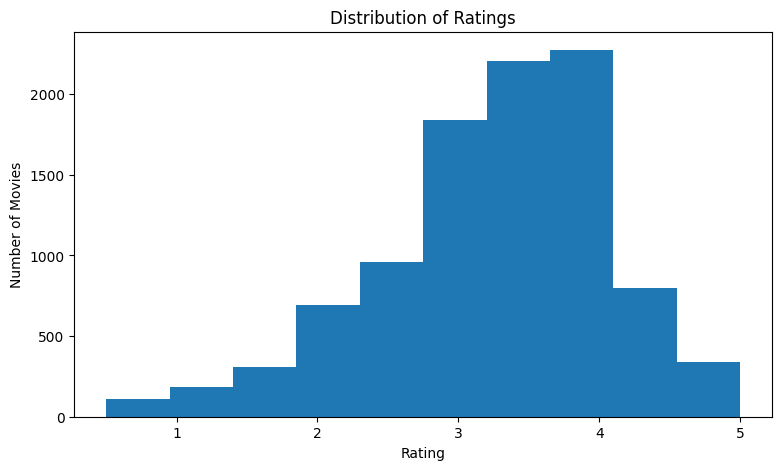

In [93]:
# Plot the distribution of ratings
plt.figure(figsize=(9,5))
plt.hist(ratings['rating'])
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.title('Distribution of Ratings')

In [104]:
# Get the top rated movies with the highest score of 5
top_rated = ratings.loc[ratings['rating'] == 5].sort_values(by='total_ratings', ascending=False)
top_rated

,rating,total_ratings
title,,
Come and See (Idi i smotri) (1985),5.0,2
Heidi Fleiss: Hollywood Madam (1995),5.0,2
Enter the Void (2009),5.0,2
Lamerica (1994),5.0,2
Belle époque (1992),5.0,2
...,...,...
Guy X (2005),5.0,1
Goodbye Charlie (1964),5.0,1
"Going Places (Valseuses, Les) (1974)",5.0,1


- Total ratings is a more reliable rating metric for movies in this dataset than rating average because those with the highest average have only been rated once or twice.

In [106]:
top_rated2 = ratings.loc[ratings['rating'] < 5].sort_values(by='rating', ascending=False)
top_rated2

,rating,total_ratings
title,,
"Trial, The (Procès, Le) (1962)",4.900000,5
What We Do in the Shadows (2014),4.833333,3
Bad Boy Bubby (1993),4.833333,3
"Awful Truth, The (1937)",4.750000,2
"Imposter, The (2012)",4.750000,2
...,...,...
Reptilicus (1961),0.500000,1
"Follow Me, Boys! (1966)",0.500000,1
Ring of Terror (1962),0.500000,1


In [111]:
# Plot movies with most ratings overall and movies with highest ratings
top_ten_ratings = ratings.sort_values(by='total_ratings', ascending=False, ).head(10)
top_ten_ratings


,rating,total_ratings,total_number_of_ratings
title,,,
"Shawshank Redemption, The (1994)",4.429022,1404.0,317
Forrest Gump (1994),4.164134,1370.0,329
Pulp Fiction (1994),4.197068,1288.5,307
"Matrix, The (1999)",4.192446,1165.5,278
"Silence of the Lambs, The (1991)",4.161290,1161.0,279
Star Wars: Episode IV - A New Hope (1977),4.231076,1062.0,251
Braveheart (1995),4.031646,955.5,237
Fight Club (1999),4.272936,931.5,218
Schindler's List (1993),4.225000,929.5,220


<Axes: ylabel='title'>

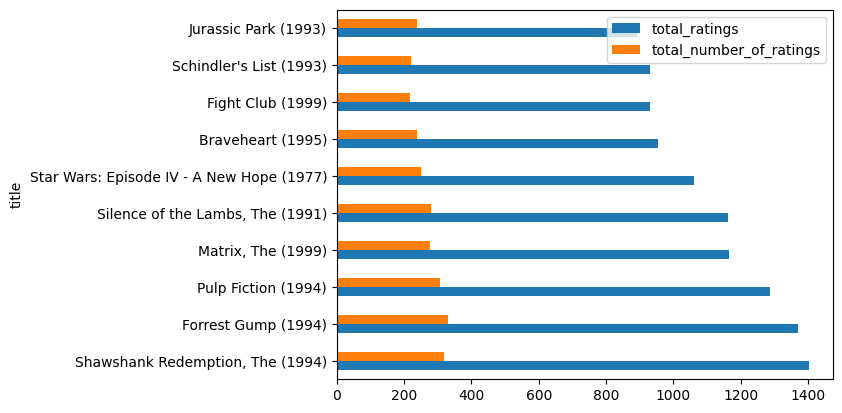

In [120]:
top_ten_ratings.plot.barh(y=['total_ratings', 'total_number_of_ratings'])

- 'The Shawshank Redemption' seems to be the most popular movie by total number of votes cast and total ratings, with an average rating of 4.2.

## 4. Modelling

The python Surprise library is going to be used as it is specialised for recommendation systems with machine learning tasks. Crossvalidation will be used here and GridsearchCV to find the best model therefore the splitting of data into training and testing will not be necessary. For the baseline model the simple memory based models(model that makes prediction based on the entire dataset saved in memory) will be used, followed by optimization of a matrix-factorization model. Test metric will RMSE(Root Mean Squares Error) as it is the most common metric used to validate such tasks.

In [129]:
# Begin with crossvalidating basic models
base_models = [
    ('knn_basic', KNNBasic(sim_options={'name':'pearson', 'user_based':True})),
    ('knn_baseline', KNNBaseline(sim_options={'name':'pearson', 'user_based':True})),
    ('knn_with_means', KNNWithMeans(sim_options={'name':'pearson', 'user_based':True})),
    ('svd_basic', SVD())
]
scores = []

# Loop through models and save results
for name, model in base_models:
    cv = cross_validate(model, data, n_jobs=-1)
    scores.append((name, np.mean(cv['test_rmse'])) )

# Display Model Performance
for name, test_score in scores:
    print(f'Model {name}:Test Score = {test_score}\n')


Model knn_basic:Test Score = 0.9729254746920304

Model knn_baseline:Test Score = 0.8778403758990585

Model knn_with_means:Test Score = 0.8973264343491056

Model svd_basic:Test Score = 0.8739315096767267



In [131]:
# Next model is a matrix-factorization model which is more efficient and scalable
params = {'n_factors': [25, 50, 75, 100],
         'reg_all': [0.02, 0.05, 0.1]}

svd_model_optimised = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
svd_model_optimised.fit(data)

print(svd_model_optimised.best_score)
print(svd_model_optimised.best_params)

{'rmse': 0.8684974777782244, 'mae': 0.6673246238295406}
{'rmse': {'n_factors': 75, 'reg_all': 0.05}, 'mae': {'n_factors': 75, 'reg_all': 0.05}}


- The  best model seems to be the optimized SVD model with n_factors of 75 and reg_all of 0.05. This will be the model selected for the collaborative filtering algorithm. 

In [136]:
# Final Model
final_model = SVD(n_factors=75, reg_all=0.05)
final_model.fit(dataset)

## 5. Conclusion

The movie recommendation model has been created and is able to make recommendatins to users after getting several of their ratings. This can be achieved in many ways and is the job beyond the scope of this modelling project.

The steps for applying recommendations is:
- The rating will be implemented by asking for user ratings of several movies from a user,then merging the new user to the dataset and recompiling. 
- The user ratings for other movies can then be predicted and all that has to be done is selecting of top five highest rated movie for that user.